1. Из всего текста отобрать комбинации смежных слов (стоящие рядом в одном предложении), содержащие слово соответствующее Вашему варианту (файл text_sent_2, word1 matrix). Если слово в варианте указано как word1, то оно должно быть только на первой позиции. На второй позиции может быть любое слово.

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import t
from scipy.stats import chi2

In [2]:
file_path = 'text_sent_2.txt'
target_word = 'matrix'

total_bigrams = 0
target_word_count = 0

In [3]:
data = {'bigramma': [], 'frequency': []}

In [4]:
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        words = line.split()
        total_bigrams += len(words) - 1

        for i in range(1, len(words)):
            if words[i - 1] == target_word:
                target_word_count += 1
                bigram = f"{target_word} {words[i]}"
                if bigram in data['bigramma']:
                    index = data['bigramma'].index(bigram)
                    data['frequency'][index] += 1
                else:
                    data['bigramma'].append(bigram)
                    data['frequency'].append(1)

In [5]:
target_word_count

128

In [6]:
total_bigrams

123625

In [7]:
tab = pd.DataFrame(data)

In [8]:
tab.to_csv('bi_tab.csv', sep=';', index=True, encoding='utf-8')

2. Проранжировать биграммы по частоте встречаемости. Сделать предварительные выводы о возможных коллокациях.

In [9]:
tab = tab.sort_values(by = 'frequency', ascending = False)

In [10]:
tab.to_csv('bi_tab_sorted.csv', sep=';', index=True, encoding='utf-8')

Collocations или коллокации — это грамматически и лексически правильные словосочетания. Проранжировав наши словосочетания по частоте встречаемости мы можем заметить, что самые часто встречающиеся сочетания вполне могут являться коллокациями, т.к. смысл в них имеется. Также мы можем предположить, что такие биграммы, например, как training of, training an, training from и training if не являются коллокациями, так как между ними не смысловая связь, а только грамматическая. Однако судить об этом по одной только частоте встречаемости может быть опрометчиво.

3. Проранжировать биграммы, отобранные в п. 2, в соответствие с критериями: хи-квадрат Пирсона и отношения правдоподобия

Извлечем из полученных биграмм все слова, стоящие на второй позиции

In [11]:
word2_all = []
for bi in tab['bigramma']:
    word2_all.extend(bi.split()[1:])

In [14]:
df = 1  # Степени свободы для 2x2 таблицы
chi2_crit = chi2.ppf(1 - 0.001, df)
print("Критическое значение для chi2 при alfa = 0.001: ", chi2_crit)
print("Критическое значение для LHR при alfa = 0.001: ", chi2_crit)

Критическое значение для chi2 при alfa = 0.001:  10.827566170662733
Критическое значение для LHR при alfa = 0.001:  10.827566170662733


In [13]:
def logL(k, n, x):
    return k * np.log(x) + (n - k) * np.log(1 - x)

In [15]:
chi2_test = []
LHR_list = []
hypothesis_list = []
chi2_hypothesis_list = []

for j in range(len(word2_all)):
    with open(file_path, 'r', encoding='utf-8') as file:
        # file.seek(0)
        O = np.zeros((2, 2))

        for line in file:
            text = line.split()
            for i in range(len(text)):
                if text[i - 1] != target_word and text[i] == word2_all[j]:
                    O[1][0] += 1

        O[0][0] = tab['frequency'].iloc[j]
        O[0][1] = target_word_count - O[0][0]
        O[1][1] = total_bigrams - O[0][0] - O[0][1] - O[1][0]

        N = total_bigrams # зачем тыщу раз считать то, что и так вычисленно
        c1 = O[0][0] + O[0][1]
        c2 = O[0][0] + O[1][0]
        c12 = O[0][0]

        p_hat = c2 / N
        p1_hat = c12 / c1
        p2_hat = (c2 - c12) / (N - c1)

        log_lambda = logL(c12, c1, p_hat) + logL(c2 - c12, N - c1, p_hat) - logL(c12, c1, p1_hat) - logL(c2 - c12, N - c1, p2_hat)

        LR = -2 * log_lambda

        if LR > chi2_crit:
            hypothesis = 'Отвергается'
        else:
            hypothesis = 'Не отвергается'
        
        LHR_list.append(LR)
        hypothesis_list.append(hypothesis)
        
        M = (O[0][0] + O[0][1]) * (O[0][0] + O[1][0]) * (O[0][1] + O[1][1]) * (O[1][0] + O[1][1])
        chi2_value = N * (O[0][0] * O[1][1] - O[0][1] * O[1][0])**2 / M
        chi2_test.append(chi2_value)

        if chi2_value > chi2_crit:
            chi2_hypothesis = 'Отвергается'
        else:
            chi2_hypothesis = 'Не отвергается'

        chi2_hypothesis_list.append(chi2_hypothesis)

new_tab1 = tab.copy()
new_tab2 = tab.copy()

new_tab1['chi2'] = chi2_test.copy()
new_tab1['chi2_hypothesis'] = chi2_hypothesis_list.copy()
new_tab1 = new_tab1.sort_values(by = 'chi2', ascending = False)

new_tab2['LHR_stat'] = LHR_list.copy()
new_tab2['hypothesis'] = hypothesis_list.copy()
new_tab2 = new_tab2.sort_values(by='LHR_stat', ascending=False)


In [16]:
new_tab1.to_csv('chi2_stat.csv', sep=';', index=True, encoding='cp1251')
new_tab2.to_csv('LHR_stat.csv', sep=';', index=True, encoding='cp1251')

4. Для анализируемых биграмм задать истинные значения переменной класса: 1 – биграмма является коллокацией (устойчивым словосочетанием), 0 – иначе. Использовать глоссарий (в конце учебника) и знания предметной области.

Используя глоссарий учебника, из которого был взят текст (James G., Witten D., Hastie T., Tibshirani R An introduction to statistical learning with
applications in R. – Switzerland: Springer, 2013. – 431 с.), получаем следующие словосочетания:
1) Matrix multiplication.

А на основе собственных знаний научной области можно добавить еще устойчивые выражения:
1) Matrix algebra;
2) Matrix operations;
3) Matrix command;
4) Matrix form;
5) Matrix function.

Для выбранных биграмм зададим значение равное 1, остальным биграмм – 0.

5. Построить ROC-кривые для оценки качества классификации биграмм как коллокаций/не коллокаций с помощью критериев Стьюдента проверки равенства вероятностей и хи-квадрат Пирсона.

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Рассчитаем для критерия хи-квадрат Пирсона

In [18]:
y_score_chi2 = new_tab1['chi2'].values

In [19]:
y_score_chi2

array([1.92576732e+03, 1.41199752e+03, 1.27738966e+03, 6.40580729e+02,
       4.81418463e+02, 4.81418463e+02, 4.81418463e+02, 1.91375119e+02,
       1.59148761e+02, 1.36130226e+02, 1.18866579e+02, 9.46980867e+01,
       8.59098222e+01, 7.23898864e+01, 7.04502565e+01, 6.24758111e+01,
       6.05421820e+01, 5.84484094e+01, 5.48949397e+01, 5.48949397e+01,
       5.29673124e+01, 4.89104711e+01, 4.63672250e+01, 4.19746239e+01,
       3.83144632e+01, 3.45030214e+01, 2.34871992e+01, 2.16286036e+01,
       1.86243885e+01, 1.63017607e+01, 1.62590227e+01, 1.47342882e+01,
       1.20880934e+01, 1.15351312e+01, 1.13882030e+01, 1.12194069e+01,
       1.04805292e+01, 9.60129171e+00, 7.23495169e+00, 6.97518131e+00,
       6.90736902e+00, 5.80749631e+00, 5.36211466e+00, 5.30528256e+00,
       5.20277823e+00, 5.00666761e+00, 4.98751203e+00, 4.77695616e+00,
       3.49798516e+00, 3.31434237e+00, 2.76698078e+00, 2.56921440e+00,
       1.23452118e+00, 6.82103823e-01, 6.30223837e-01, 6.18823186e-01,
      

Заполним истинные значения, соотвествующие критерию хи-квадрат Пирсона в нашей таблице

In [21]:
y_true_chi2 = np.array([1, 0, 0, 0, 
                        1, 0, 1, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0,
                        0, 0, 0, 0, 
                        0, 1, 0, 1, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 1, 0, 
                        0, 0, 0, 0,
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0])

In [22]:
y_score_chi2.shape

(65,)

In [23]:
y_true_chi2.shape

(65,)

In [24]:
fpr_chi2, tpr_chi2, _ = roc_curve(y_true_chi2, y_score_chi2)
roc_auc_chi2 = auc(fpr_chi2, tpr_chi2)

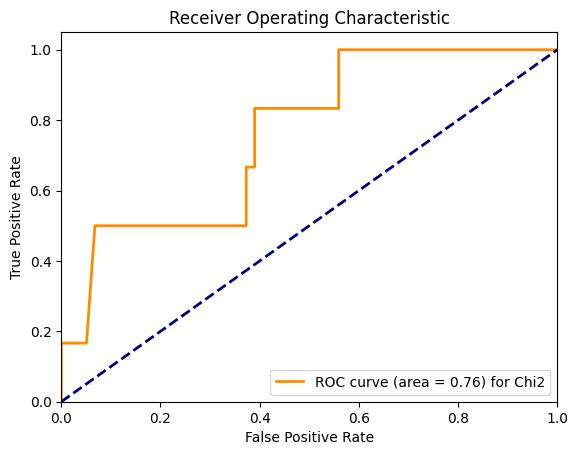

In [25]:
plt.figure()
plt.plot(fpr_chi2, tpr_chi2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_chi2:.2f}) for Chi2')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Здесь диагональная линия показывает, как бы выглядела ROC-кривая для классификатора, который просто случайным образом предсказывает классы. Наша ROC-кривая лежит выше этой линии, это означает, что ваш классификатор работает лучше, чем случайное угадывание.

Чем дальше ваша ROC-кривая от диагональной линии, тем лучше качество классификации. Идеальный классификатор будет иметь ROC-кривую, которая стремится к левому верхнему углу графика (TPR = 1, FPR = 0).

In [28]:
y_score_LHR = new_tab2['LHR_stat'].values

In [29]:
y_score_LHR

array([5.41985322e+01, 4.83542600e+01, 4.40276896e+01, 1.98932810e+01,
       1.30232811e+01, 1.09832474e+01, 1.09832474e+01, 1.09832474e+01,
       1.06708308e+01, 1.01042419e+01, 9.61190232e+00, 8.75797904e+00,
       8.35732451e+00, 8.02448633e+00, 7.73984799e+00, 7.27062271e+00,
       7.14480512e+00, 7.07234387e+00, 6.72752602e+00, 6.47633492e+00,
       6.43466070e+00, 6.30328434e+00, 6.18025876e+00, 6.18025876e+00,
       5.95548734e+00, 5.85223151e+00, 5.66102769e+00, 5.65576319e+00,
       5.51028628e+00, 5.48721541e+00, 5.22653955e+00, 4.60874943e+00,
       4.58122915e+00, 4.43346755e+00, 4.16949294e+00, 3.93910185e+00,
       3.92111323e+00, 3.76743617e+00, 3.43995498e+00, 3.25634560e+00,
       3.21157463e+00, 3.07477735e+00, 2.65230349e+00, 2.58610558e+00,
       2.22626635e+00, 2.20086123e+00, 2.15132712e+00, 2.13190164e+00,
       2.09167987e+00, 1.78627030e+00, 1.66234767e+00, 1.40069786e+00,
       8.16031971e-01, 6.02514437e-01, 5.33061909e-01, 5.12600536e-01,
      

In [30]:
y_true_LHR =  np.array([0, 0, 1, 0, 
                        1, 1, 0, 1, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0,
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        1, 0, 0, 0, 
                        0, 1, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0,
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0, 
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0])

In [31]:
y_score_LHR.shape

(65,)

In [32]:
y_true_LHR.shape

(65,)

In [33]:
fpr_LHR, tpr_LHR, _ = roc_curve(y_true_LHR, y_score_LHR)
roc_auc_LHR = auc(fpr_LHR, tpr_LHR)

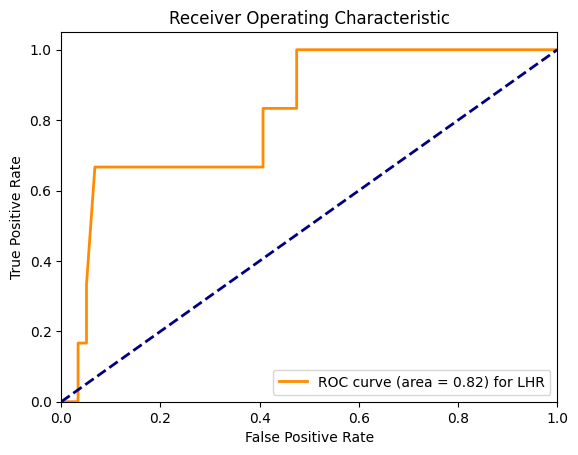

In [34]:
plt.figure()
plt.plot(fpr_LHR, tpr_LHR, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_LHR:.2f}) for LHR')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

6) Сравнить критерии по качеству классификации на основе показателя AUC (площади под ROC-кривой). Сделать выводы

AUC — это площадь под ROC-кривой. Она является важной метрикой, которая позволяет оценить качество классификации:

AUC = 1: Идеальная классификация.

AUC = 0.5: Классификатор работает как случайное угадывание.

AUC < 0.5: Классификатор работает хуже, чем случайное угадывание.

Исходя из полученных данных, мы можем сделать следующие выводы:

Значение AUC для критерия Стьюдента близко к 1, что указывает на очень хорошее качество классификации. Классификатор, использующий критерий Стьюдента, работает почти идеально. Классификатор с таким высоким AUC хорошо различает коллокации и не коллокации.

Значение AUC 0.86 также указывает на хорошее качество классификации, хотя и не такое высокое, как в случае с критерием Стьюдента. Классификатор, использующий критерий хи-квадрат, также хорошо различает коллокации и не коллокации, но не так эффективно, как в случае с критерием Стьюдента.